In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_cleaning_script import wrangle

In [2]:
data = wrangle("custom-import_data.csv")
data.head()

c:\Users\USER\Desktop\Dataverse\TRADE&CUSTOMS\data_cleaning_script.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


(77789, 16)
Unnamed: 0             int64
Custom Office         object
Reg Number            object
Importer               int64
HS Code                int64
FOB Value (N)          int64
CIF Value (N)          int64
Total Tax(N)           int64
Receipt Number        object
Receipt Date          object
Mass(KG)              object
Country  of Origin    object
Country  of Supply    object
Nbr Of Containers     object
Container Nbr         object
Container Size        object
dtype: object


,Custom Office,Reg Number,Importer,HS Code,FOB Value (N),CIF Value (N),Total Tax(N),Receipt Number,Receipt Date,Mass(KG),Country of Origin,Country of Supply,Nbr Of Containers,Container Nbr,Container Size
0,UA PORT,C1195,29143,12900000,1046575,1119220,137105,R599,2021-07-03,126,Germany,Germany,0,N/A,N/A
1,UA PORT,C1195,29143,36700000,216957,232002,68365,R599,2021-07-03,26,Germany,Germany,0,N/A,N/A
2,UA PORT,C1195,29143,39390000,172037,183858,54415,R599,2021-07-03,21,Germany,Germany,0,N/A,N/A
3,UA PORT,C1277,62056,40890000,776007,915286,162868,R621,2021-08-03,71,Belgium,Belgium,0,N/A,N/A
4,UA PORT,C1292,93763,37100000,234651,301040,37415,R614,2021-08-03,45,Turkey,Turkey,0,N/A,N/A


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77789 entries, 0 to 77788
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Custom Office       77789 non-null  object        
 1   Reg Number          77789 non-null  object        
 2   Importer            77789 non-null  object        
 3   HS Code             77789 non-null  object        
 4   FOB Value (N)       77789 non-null  int64         
 5   CIF Value (N)       77789 non-null  int64         
 6   Total Tax(N)        77789 non-null  int64         
 7   Receipt Number      77789 non-null  object        
 8   Receipt Date        76493 non-null  datetime64[ns]
 9   Mass(KG)            77789 non-null  int64         
 10  Country  of Origin  77789 non-null  object        
 11  Country  of Supply  77789 non-null  object        
 12  Nbr Of Containers   77789 non-null  int64         
 13  Container Nbr       77789 non-null  object    

In [4]:
# Transaction Volumes by Office
trans_vol = data.groupby("Custom Office")["Reg Number"].count().sort_values(ascending=False).reset_index()
# Calculate the percentage
trans_vol["Percentage"] = round((trans_vol["Reg Number"] /
                           trans_vol["Reg Number"].sum()) * 100, 2)

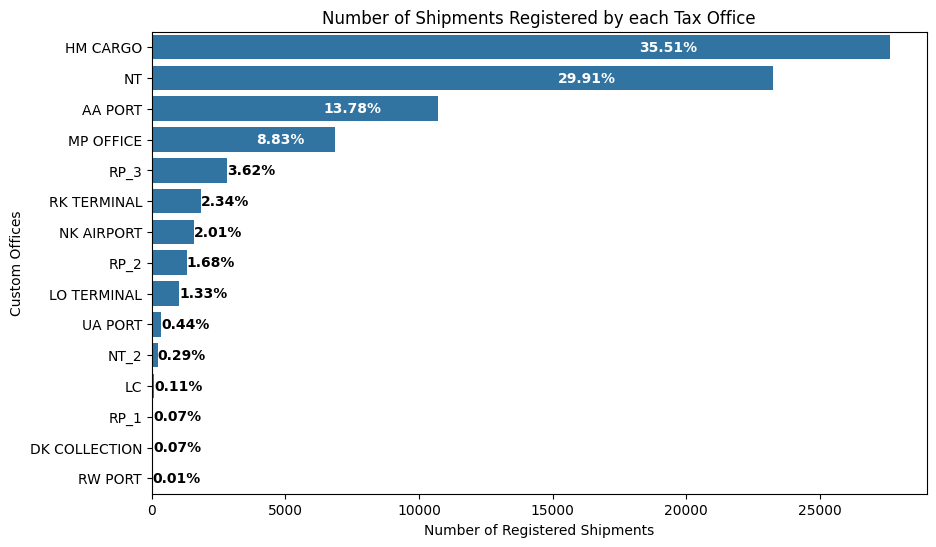

In [5]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=trans_vol, y="Custom Office", x="Reg Number")
# Annotate bars: inside if wide enough, else outside
for bar, pct in zip(ax.patches, trans_vol["Percentage"]):
    width = bar.get_width()
    threshold = 4000  
    if width > threshold:
        # Place inside the bar
        ax.text(
            width * 0.7,
            bar.get_y() + bar.get_height() / 2,
            f"{pct:.2f}%",
            va="center",
            ha="center",
            color="white",
            fontweight="bold"
        )
    else:
        # Place outside the bar
        ax.text(
            width * 1,
            bar.get_y() + bar.get_height() / 2,
            f"{pct:.2f}%",
            va="center",
            ha="left",
            color="black",
            fontweight="bold"
        )
plt.title("Number of Shipments Registered by each Tax Office")
plt.xlabel("Number of Registered Shipments")
plt.ylabel("Custom Offices")
plt.show();

* Some offices like HM CARGO and NT registred more share of the total registered imports
* Others like UA PORT, NT_2, LC, RP_1, DK_COLLECTION, and RW PORT had less than 1% of the total registered imports

In [6]:
# Then we'll check revenue collection per each office
office_tax = (data.groupby("Custom Office")["Total Tax(N)"]
              .mean()
              .sort_values(ascending=False)
              .reset_index()
)

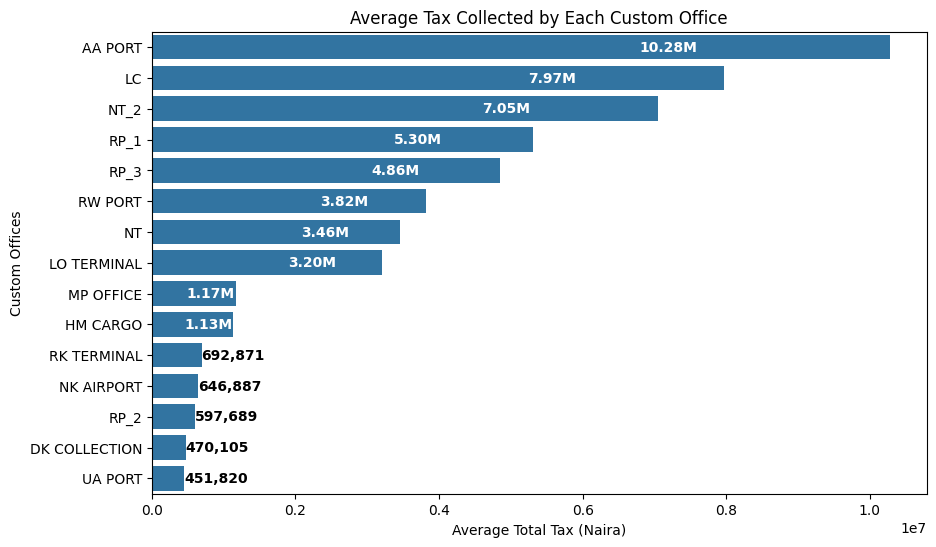

In [7]:
plt.figure(figsize=(10,6))
ax = sns.barplot(data=office_tax, x="Total Tax(N)", y="Custom Office")

# Helper function to format numbers
def format_billions_millions(x):
    if x >= 1e9:
        return f"{x/1e9:.2f}B"
    elif x >= 1e6:
        return f"{x/1e6:.2f}M"
    else:
        return f"{x:,.0f}"

# Annotate bars with formatted values
for bar, value in zip(ax.patches, office_tax["Total Tax(N)"]):
    width = bar.get_width()
    threshold = 7e5
    if width > threshold:
        ax.text(
            width * 0.7,
            bar.get_y() + bar.get_height() / 2,
            format_billions_millions(value),
            va="center",
            ha="center",
            color="white",
            fontweight="bold"
    )
    else:
        ax.text(
            width * 1,
            bar.get_y() + bar.get_height() / 2,
            format_billions_millions(value),
            va="center",
            ha="left",
            color="black",
            fontweight="bold"
        )
    
plt.title("Average Tax Collected by Each Custom Office")
plt.xlabel("Average Total Tax (Naira)")
plt.ylabel("Custom Offices")
plt.show();

* We can see companies who registered less than 1% of the total shipments, among the top 6 with high average tax amounts
* It's possible that might be because some specialized products pass through these places and are highly taxed
* And custom offices through which most of the shipments passed through, had a much lower average tax amount

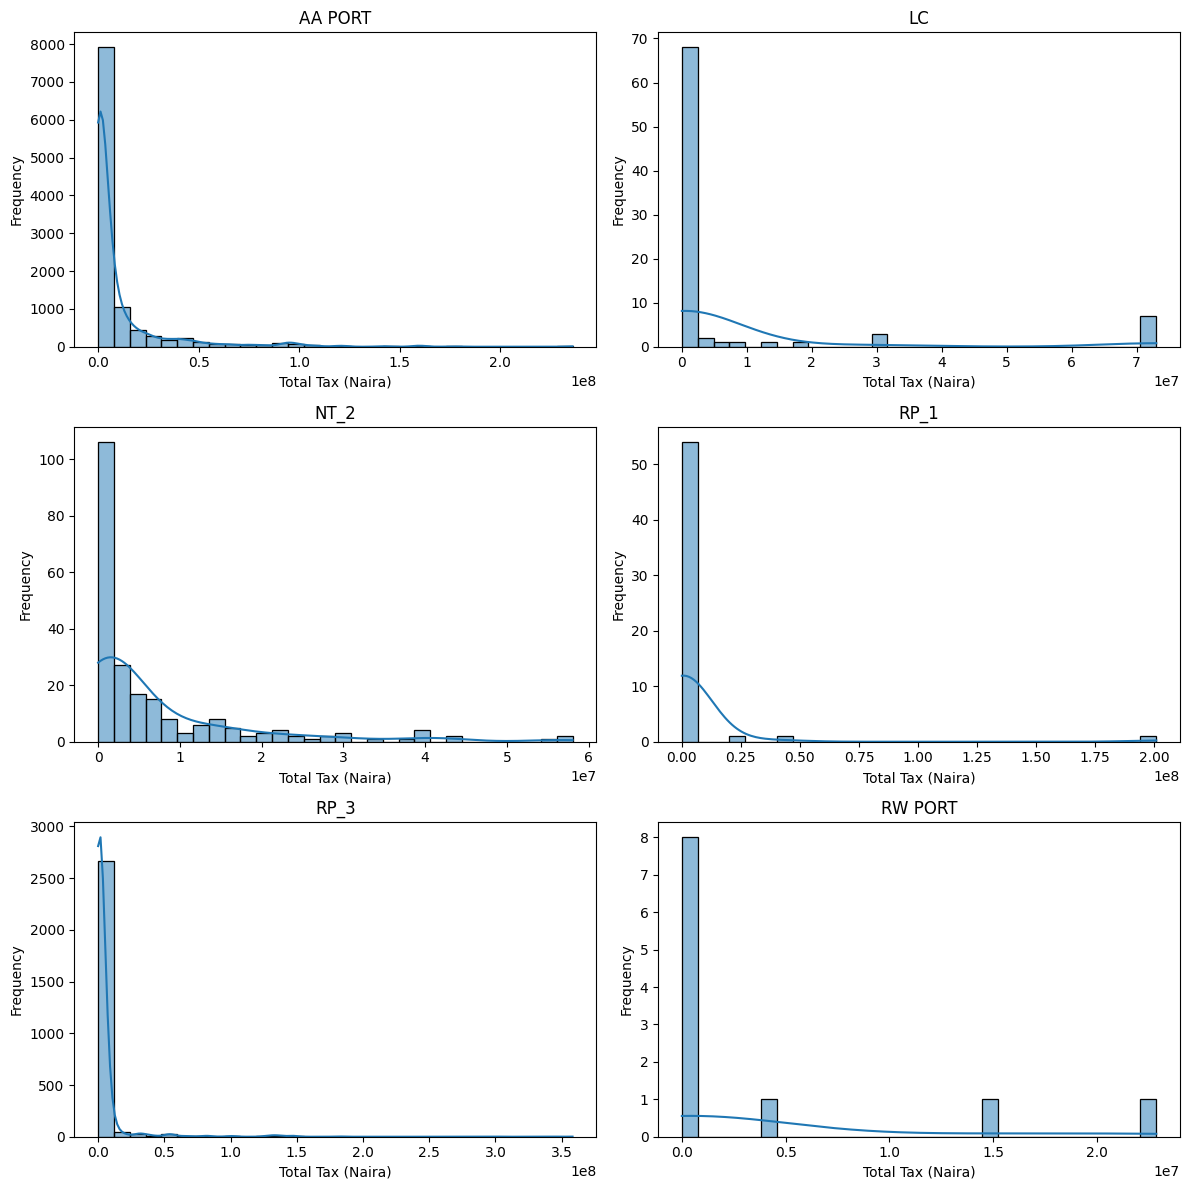

In [16]:
# Drop DK COLLECTION
sus_offices = office_tax["Custom Office"].head(6).to_list()
# Plot a separate histogram for each office in a grid
import math
num_offices = len(sus_offices)
cols = 2
rows = math.ceil(num_offices / cols)
plt.figure(figsize=(12, 4 * rows))
for i, office in enumerate(sus_offices, 1):
    office_data = data[data["Custom Office"] == office]
    plt.subplot(rows, cols, i)
    sns.histplot(office_data["Total Tax(N)"], kde=True, bins=30, color=None)
    plt.title(f"{office}")
    plt.xlabel("Total Tax (Naira)")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

* It can be seen that most goods processed through these customs offices are heavily taxed

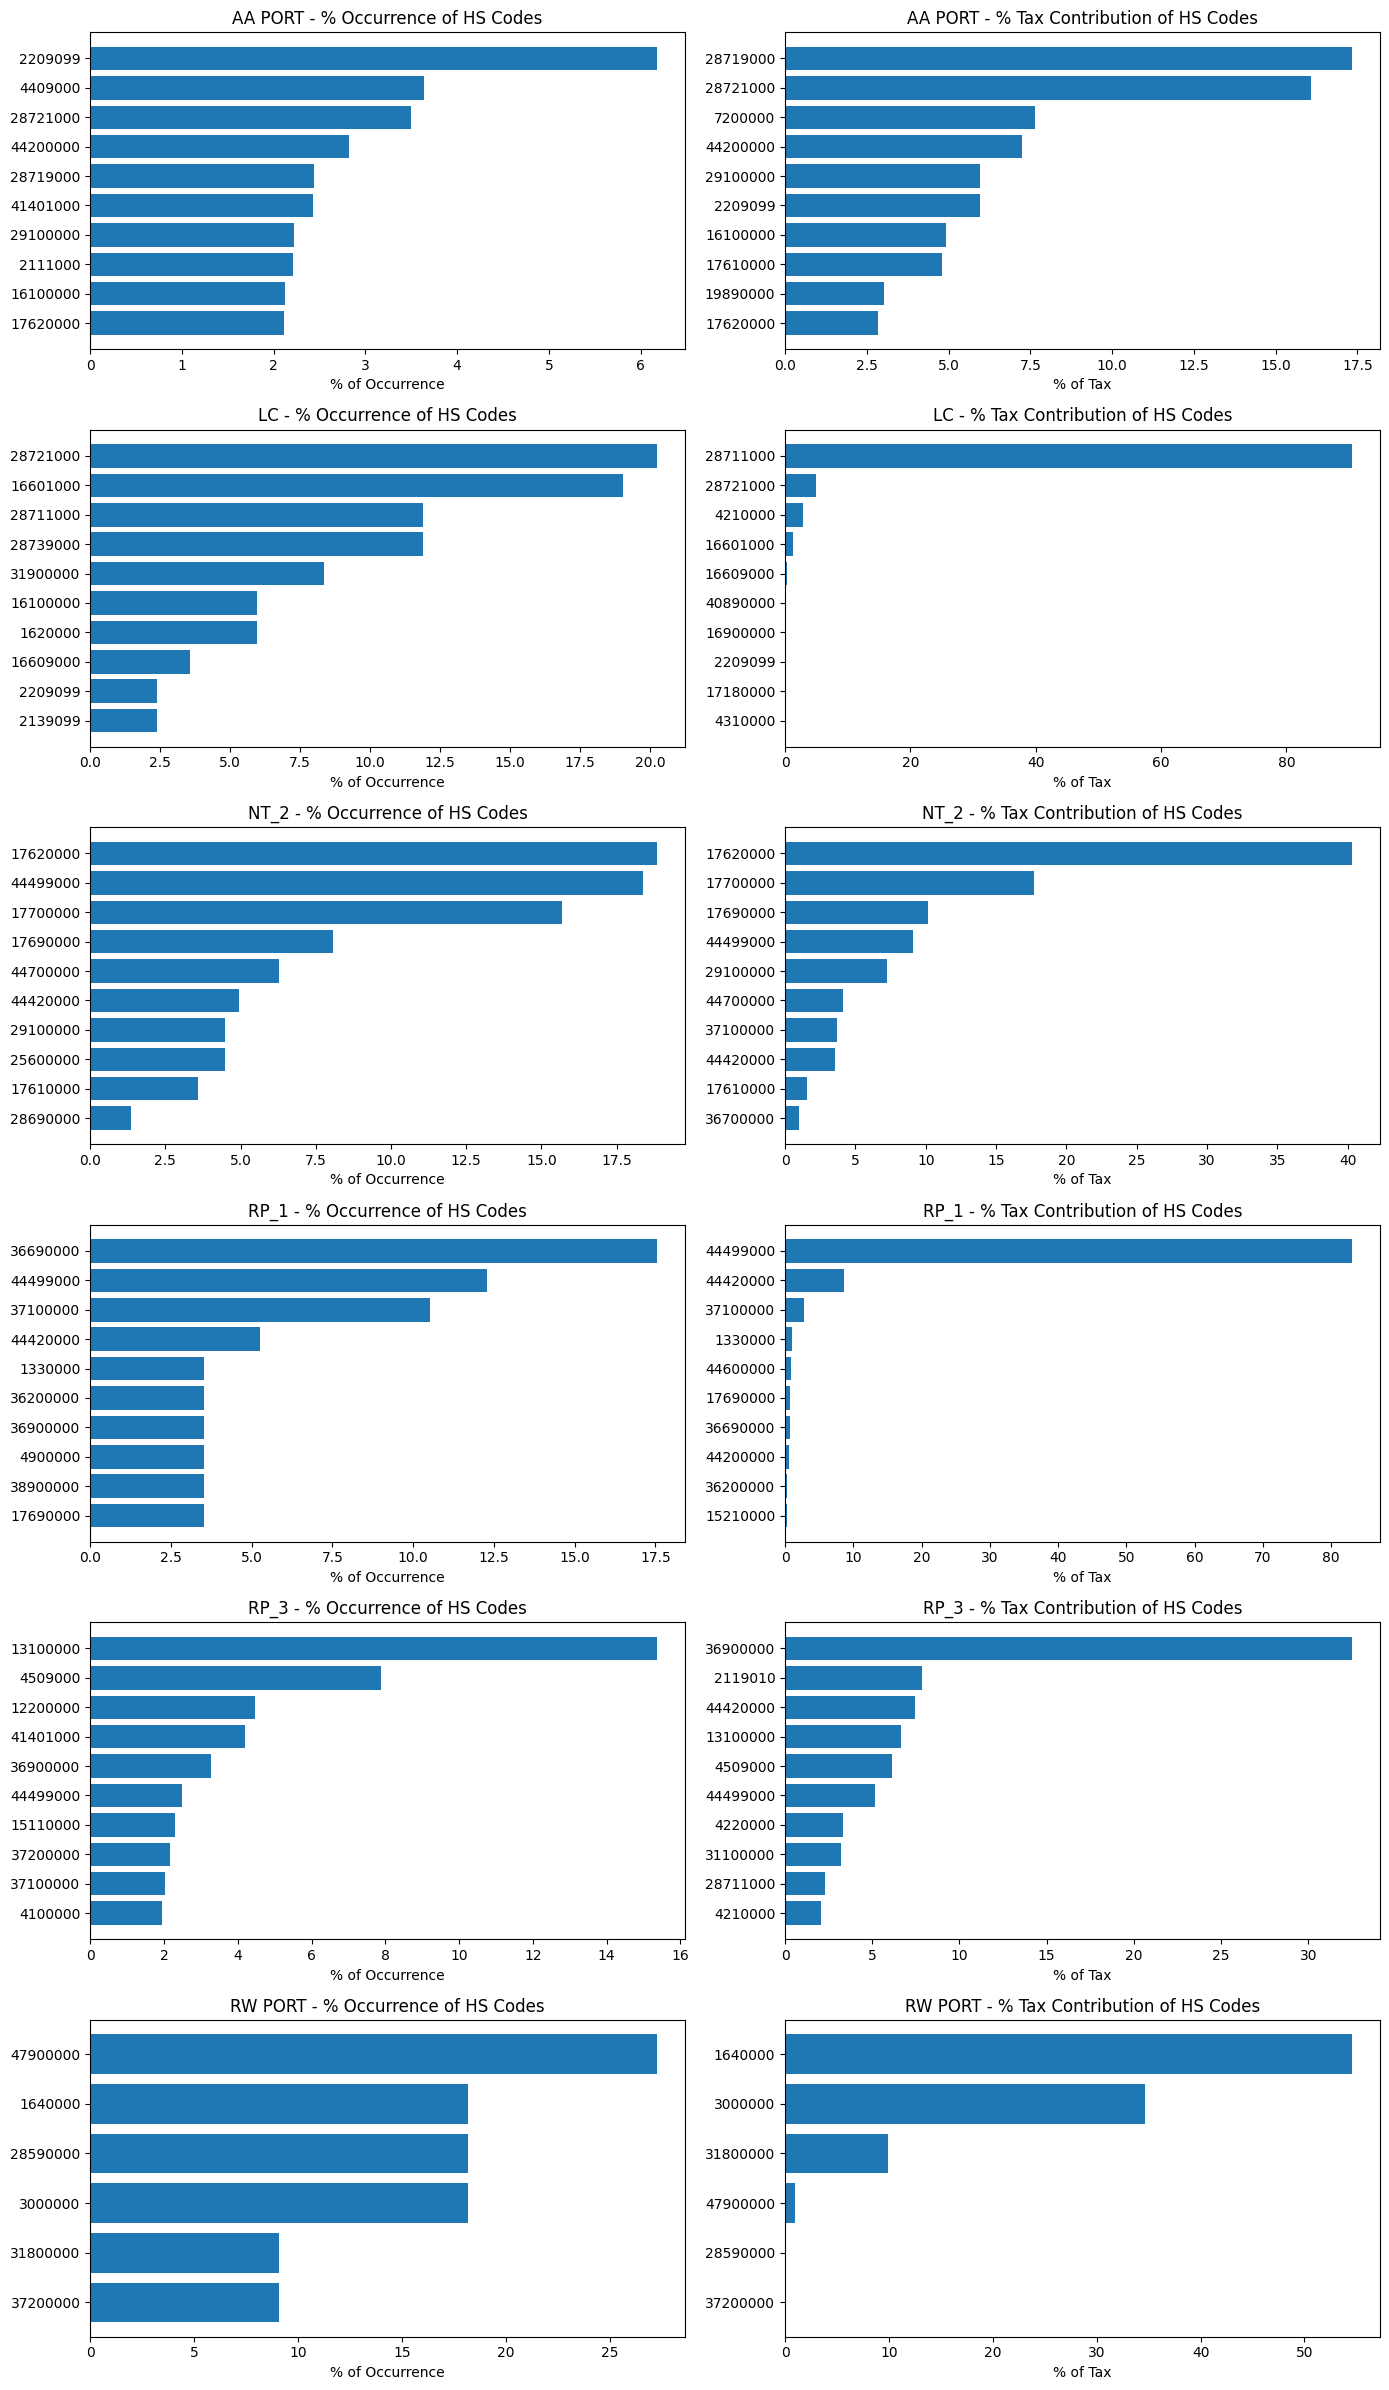

In [50]:
#Which goods are passed through these offices?
# Filter data for selected offices
filtered = data[data["Custom Office"].isin(sus_offices)]

# Group by office + HS code for counts and tax
hs_stats = (
    filtered.groupby(["Custom Office", "HS Code"])
    .agg(
        count=("HS Code", "size"),
        total_tax=("Total Tax(N)", "sum")   # replace with your tax column name
    )
    .reset_index()
)

# Normalize within each office for counts
hs_stats["pct_occurrence"] = hs_stats.groupby("Custom Office")["count"].transform(lambda x: x / x.sum() * 100)

# Normalize within each office for tax
hs_stats["pct_tax"] = hs_stats.groupby("Custom Office")["total_tax"].transform(lambda x: x / x.sum() * 100)

# ---- Plotting ----
fig, axes = plt.subplots(len(sus_offices), 2, figsize=(14, 4 * len(sus_offices)))

for i, office in enumerate(sus_offices):
    office_data = hs_stats[hs_stats["Custom Office"] == office].sort_values("pct_occurrence", ascending=False).head(10)
    
    # Plot percentage occurrence
    axes[i, 0].barh(office_data["HS Code"].astype(str), office_data["pct_occurrence"])
    axes[i, 0].set_title(f"{office} - % Occurrence of HS Codes")
    axes[i, 0].invert_yaxis()
    axes[i, 0].set_xlabel("% of Occurrence")
    
    # Plot percentage tax
    office_data = hs_stats[hs_stats["Custom Office"] == office].sort_values("pct_tax", ascending=False).head(10)
    axes[i, 1].barh(office_data["HS Code"].astype(str), office_data["pct_tax"])
    axes[i, 1].set_title(f"{office} - % Tax Contribution of HS Codes")
    axes[i, 1].invert_yaxis()
    axes[i, 1].set_xlabel("% of Tax")

plt.tight_layout()
plt.show()


<Axes: xlabel='Mass(KG)', ylabel='Total Tax(N)'>

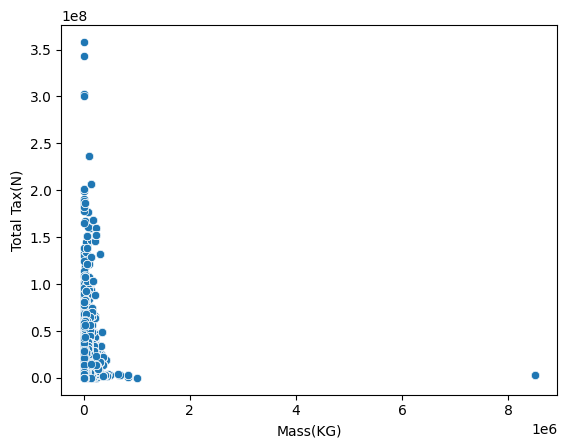

In [17]:
# Check whether the masses of these products influence the tax paid
sns.scatterplot(data=data, x="Mass(KG)", y="Total Tax(N)")

In [27]:
zero_mass = data[data["Mass(KG)"] == 0]

<Axes: xlabel='Reg Number', ylabel='Custom Office'>

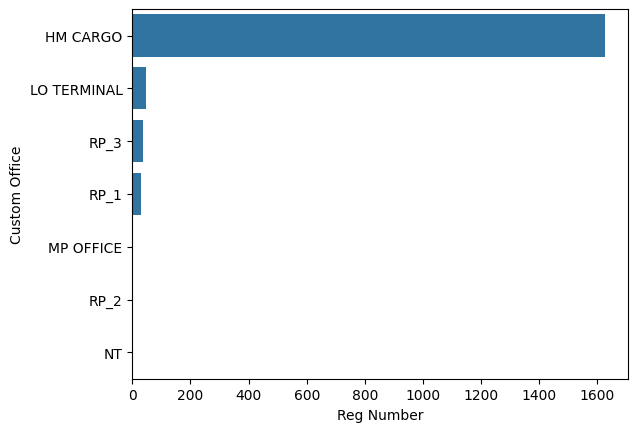

In [32]:
zm_offices = (zero_mass.groupby("Custom Office")["Reg Number"]
              .count()
              .sort_values(ascending=False)
              .reset_index()
)

# Plot
sns.barplot(data=zm_offices, x="Reg Number", y="Custom Office")

In [45]:
# filter for where mass = 0 and custom_office = HM CARGo
mask = (data["Mass(KG)"] == 0) & (data["Custom Office"] == "HM CARGO")
data.loc[mask, "HS Code"].value_counts()

HS Code
17120000    417
44420000     97
17700000     91
36500000     89
7600000      84
           ... 
32210000      1
28729000      1
14900000      1
5201000       1
44190000      1
Name: count, Length: 146, dtype: int64

In [48]:
data[data["HS Code"] == '17120000']

,Custom Office,Reg Number,Importer,HS Code,FOB Value (N),CIF Value (N),Total Tax(N),Receipt Number,Receipt Date,Mass(KG),Country of Origin,Country of Supply,Nbr Of Containers,Container Nbr,Container Size
209,UA PORT,C4499,90098,17120000,87884800,88962532,15834228,R1892,2021-09-23,990,Denmark,Denmark,0,N/A,N/A
291,UA PORT,C5903,8232,17120000,64125,89440,16981,R2347,2021-12-14,8,Belgium,Belgium,0,N/A,N/A
833,AA PORT,C12708,56283,17120000,7681842,8160749,1450318,R14483,2021-03-18,7998,China,China,1,TRHU2317138,20GP
2242,AA PORT,C18231,80918,17120000,95211700,98516572,1600,Unknown,NaT,2446,China,China,1,MRSU0126654,22G1
4159,AA PORT,C29385,93155,17120000,2256856,2501727,444903,R35782,2021-07-19,4000,United Arab Emirates,United Arab Emirates,1,PONU0603648,22G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44068,RP_2,C4349,1195,17120000,739060,850444,151612,R4459,2021-09-09,170,United Arab Emirates,United Arab Emirates,0,Unknown,Unknown
45976,RP_3,C24039,62837,17120000,2588899,2749766,489361,R25889,2021-10-21,800,Singapore,Singapore,1,CMAU1746447,22G1
46543,RP_3,C3649,62837,17120000,1880980,2046066,363989,R4171,2021-09-02,1000,Singapore,Singapore,0,Unknown,Unknown
56030,NT,C109810,77019,17120000,18987850,20560125,3646567,R128007,2021-09-11,12180,China,China,1,DAYU6104063,40DV


In [42]:
# Group by Customs Office and HS Code to count transactions
hs_counts = data.groupby(["Custom Office", "HS Code"]).size().reset_index(name="count")

# Normalize within each Customs Office → share of each HS code
hs_counts["share"] = hs_counts.groupby("Custom Office")["count"].transform(lambda x: (x / x.sum())*100)

# Sort for readability
hs_counts = hs_counts.sort_values(["Custom Office", "share"], ascending=[True, False])

In [41]:
# Get top 3 HS Codes per Customs Office
top3_hs_per_office = hs_counts.groupby("Custom Office").head(3)

top3_hs_per_office


,Custom Office,HS Code,count,share
92,AA PORT,2209099,662,6.175373
215,AA PORT,4409000,390,3.638060
130,AA PORT,28721000,375,3.498134
281,DK COLLECTION,41401000,12,21.818182
286,DK COLLECTION,4900000,12,21.818182
268,DK COLLECTION,13100000,3,5.454545
351,HM CARGO,17620000,3612,13.077954
348,HM CARGO,17120000,2072,7.502082
353,HM CARGO,17700000,1789,6.477425
583,LC,28721000,17,20.238095


## Advanced Analysis

In [53]:
import statsmodels.api as sm

               FOB Value (N)  CIF Value (N)  Mass(KG)  Total Tax(N)
FOB Value (N)       1.000000       0.999262  0.200850      0.714473
CIF Value (N)       0.999262       1.000000  0.203414      0.721517
Mass(KG)            0.200850       0.203414  1.000000      0.166087
Total Tax(N)        0.714473       0.721517  0.166087      1.000000


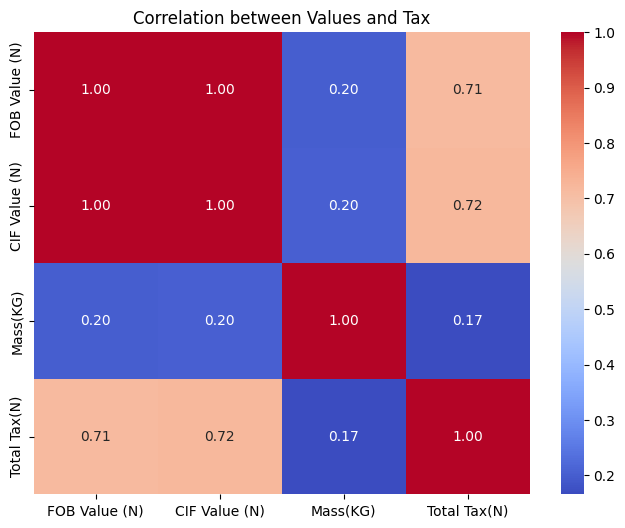

In [52]:
# check correlation between FOB/CIF valus

# Select relevant columns
corr_data = data[["FOB Value (N)", "CIF Value (N)", "Mass(KG)", "Total Tax(N)"]]

# Calculate correlation matrix
corr_matrix = corr_data.corr(method="pearson")

print(corr_matrix)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Values and Tax")
plt.show()

* FOB and CIF have a perfect 1.0 correlation, which is expected
* CIF vs Total Tax has a strong positive correlation of 0.72, and FOB vs Total Tax also has a strong correlation of 0.71, suggesting that tax is largely driven by the value of goods.
* Mass and Tax have a very weak correlation, suggesting that mass doesn't explain tax.
* Overall, Tax seems to be levied based on the value of the product, not the weight

In [56]:
# Regression Analysis
X = data["CIF Value (N)"]
y = data["Total Tax(N)"]

# Add constant for intercept
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Total Tax(N)   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                 8.447e+04
Date:                Wed, 10 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:45:14   Log-Likelihood:            -1.3563e+06
No. Observations:               77789   AIC:                         2.713e+06
Df Residuals:                   77787   BIC:                         2.713e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.819e+05   3.34e+04     26.391

* The R-squared value of 0.521, shows that only about 52.1% of variation in tax can be explained by CIF value
* The Coefficient of the CIF value is approx. 0.095, showing that for every #1 increase in the CIF value, tax increases by #0.095, in simple words, approximately 9.5% of the CIF alue is taken as tax.
* Model also shows a baseline charge of about #881,900 even at a CFI value = 0


In [64]:
# Regression Analysis
X = data["Mass(KG)"]
y = data["Total Tax(N)"]

# Add constant for intercept
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Total Tax(N)   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2207.
Date:                Wed, 10 Sep 2025   Prob (F-statistic):               0.00
Time:                        22:24:01   Log-Likelihood:            -1.3838e+06
No. Observations:               77789   AIC:                         2.768e+06
Df Residuals:                   77787   BIC:                         2.768e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.86e+06   4.69e+04     61.002      0.0

* The R-squared value shows that only 2.8% of taxes could be explained by the mass, showing that the mass isn't a major factor that drives tax incurred.

In [58]:
X = data[["FOB Value (N)", "CIF Value (N)", "Mass(KG)"]].dropna()
y = data.loc[X.index, "Total Tax(N)"]

X = sm.add_constant(X)

multi_model = sm.OLS(y, X).fit()
print(multi_model.summary())


                            OLS Regression Results                            
Dep. Variable:           Total Tax(N)   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                 3.161e+04
Date:                Wed, 10 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:46:39   Log-Likelihood:            -1.3539e+06
No. Observations:               77789   AIC:                         2.708e+06
Df Residuals:                   77785   BIC:                         2.708e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.034e+05    3.3e+04     15.246

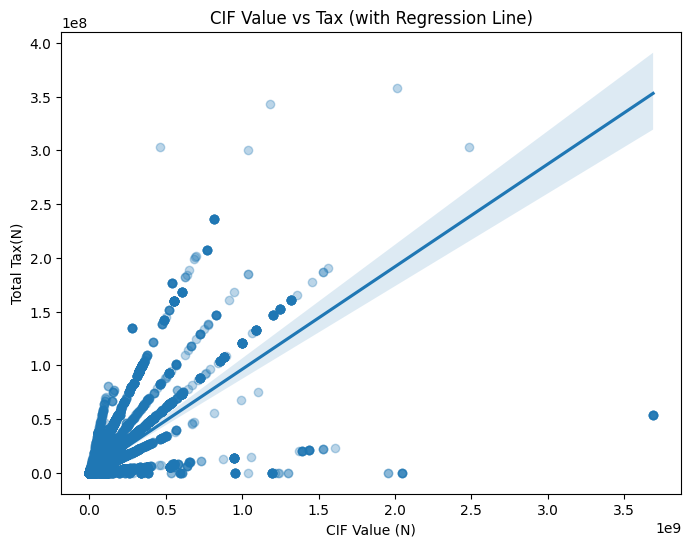

In [59]:
plt.figure(figsize=(8,6))
sns.regplot(x="CIF Value (N)", y="Total Tax(N)", data=data, scatter_kws={"alpha":0.3})
plt.title("CIF Value vs Tax (with Regression Line)")
plt.show()

In [72]:
grouped_corr = {}

for office, df_office in data.groupby("Custom Office"):
    # calculate correlation only if enough rows exist
    if df_office.shape[0] > 30:  # threshold to avoid noise
        corr = df_office["CIF Value (N)"].corr(df_office["Total Tax(N)"])
        grouped_corr[office] = corr

# Convert to DataFrame
office_corr = pd.DataFrame(list(grouped_corr.items()), columns=["Custom Office", "Correlation"])
office_corr = office_corr.sort_values("Correlation", ascending=False)
office_corr


,Custom Office,Correlation
10,RP_1,0.998997
6,NK AIRPORT,0.908780
8,NT_2,0.906380
7,NT,0.890528
2,HM CARGO,0.841394
11,RP_2,0.826204
13,UA PORT,0.742635
5,MP OFFICE,0.737093
3,LC,0.656045
0,AA PORT,0.647644


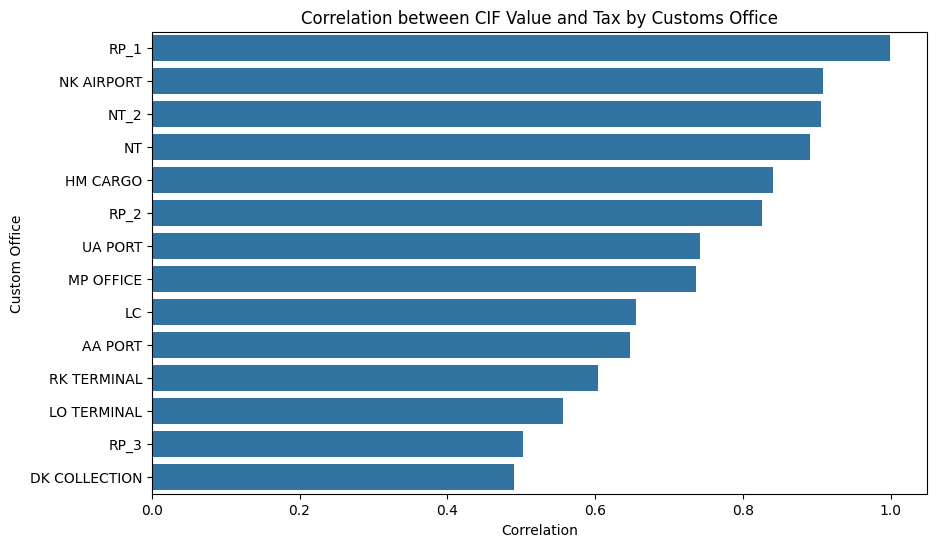

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=office_corr, x="Correlation", y="Custom Office")
plt.title("Correlation between CIF Value and Tax by Customs Office")
plt.show();


In [93]:
grouped_corr = {}

for country_of_supply, df_country_of_supply in data.groupby("Country  of Supply"):
    # calculate correlation only if enough rows exist
    if df_country_of_supply.shape[0] > 4:  # threshold to avoid noise
        corr = df_country_of_supply["CIF Value (N)"].corr(df_country_of_supply["Total Tax(N)"])
        grouped_corr[country_of_supply] = corr

# Convert to DataFrame
country_corr = pd.DataFrame(list(grouped_corr.items()), columns=["Country of Supply", "Correlation"])
country_corr = country_corr.sort_values("Correlation", ascending=False)
country_corr

,Country of Supply,Correlation
20,Estonia,0.999999
46,Mexico,0.999986
51,Pakistan,0.999966
37,Kenya,0.999952
2,Aruba,0.999938
...,...,...
71,United Arab Emirates,0.356047
31,India,0.232308
63,Swaziland,0.160355
65,Switzerland,0.122585


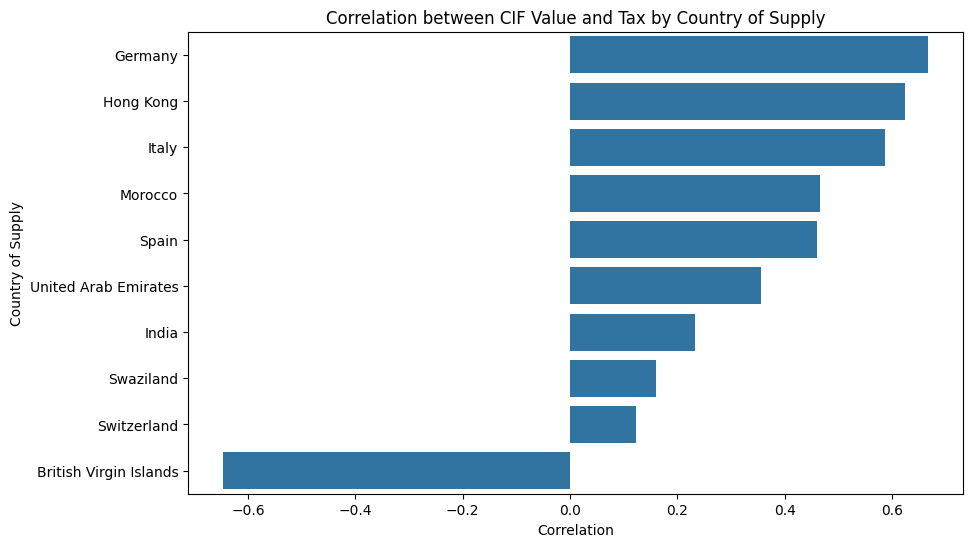

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=country_corr.tail(10), x="Correlation", y="Country of Supply")
plt.title("Correlation between CIF Value and Tax by Country of Supply")
plt.show();